
The idea of this implementation is to build an Amharic Handwritten and Machine Printed Optical Character Recognition (OCR) using CNN with Random Search Hyperparameter Optimization Algorithm. The initial CNN architecture uses some random hyperparameter values, and it scored 95% accuracy with unseen data. After applying random search within a specific search space, the results improved to 96%, and moreover, the time it took decreased.


In [ ]:
# Helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils
import sys
import gc
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import imutils
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import os.path
import glob

In [ ]:
# Show an example of data
dir = "/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Split/train/"
train_data = []
#img_size = 28
non_chars = ["#","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        #img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [ ]:
len(train_data)

83219

In [ ]:
val_dir = "/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Split/val/"
val_data = []
#img_size = 28
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        #img = cv2.resize(img,(img_size,img_size))ddd
        val_data.append([img,i])

In [ ]:
len(val_data)

10292

In [ ]:
test_dir = "/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Split/test/"
test_data = []
#img_size = 28
non_chars = ["#","&","@"]
for i in os.listdir(test_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(test_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        #img = cv2.resize(img,(img_size,img_size))
        test_data.append([img,i])

In [ ]:
# save nump array data
np.save('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/train_data.npy', train_data)
np.save('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/val_data.npy', val_data)
np.save('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/test_data.npy', test_data)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#load nump array data
train_data_arry = np.load('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/train_data.npy',allow_pickle=True)
val_data_arry = np.load('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/val_data.npy', allow_pickle=True)
test_data_arry = np.load('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/test_data.npy', allow_pickle=True)

In [ ]:
len(train_data_arry), len(val_data_arry),len(test_data_arry)

(83219, 10292, 10666)

In [ ]:
#Randomly shuffling
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

In [ ]:
#Preparing the featurevof training
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [ ]:
#Preparing the featurevof validation
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [ ]:
##Preparing the featurevof testing
test_X = []
test_Y = []
for features,label in test_data:
    test_X.append(features)
    test_Y.append(label)

In [ ]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)
test_Y = LB.fit_transform(test_Y)


In [ ]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,28,28,1)
train_Y = np.array(train_Y)

In [ ]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,28,28,1)
val_Y = np.array(val_Y)

In [ ]:
test_X = np.array(test_X)/255.0
test_X = test_X.reshape(-1,28,28,1)
test_Y = np.array(test_Y)

In [ ]:
print(train_X.shape,val_X.shape, test_X.shape)

(83219, 28, 28, 1) (10292, 28, 28, 1) (10666, 28, 28, 1)


In [ ]:
print(train_Y.shape,val_Y.shape, test_Y.shape)

(83219, 302) (10292, 302) (10666, 302)


In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.25))
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.25))
    model[j].add(Dense(302, activation='softmax'))

In [ ]:
   # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model[j].compile(loss='CategoricalCrossentropy', optimizer="Adam", metrics=['accuracy'])

In [ ]:
#Saving the model
model[j].save("/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/AmharicModelA.h5") #using h5 extension
print("model saved!!!")

model saved!!!


In [ ]:
history = model[j].fit(train_X,train_Y, epochs=30, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/30
2601/2601 [==============================] - 385s 147ms/step - loss: 2.0889 - accuracy: 0.5157 - val_loss: 0.6681 - val_accuracy: 0.8062
Epoch 2/30
2601/2601 [==============================] - 373s 143ms/step - loss: 0.6903 - accuracy: 0.7997 - val_loss: 0.3882 - val_accuracy: 0.8827
Epoch 3/30
2601/2601 [==============================] - 374s 144ms/step - loss: 0.5108 - accuracy: 0.8481 - val_loss: 0.3134 - val_accuracy: 0.9065
Epoch 4/30
2601/2601 [==============================] - 374s 144ms/step - loss: 0.4279 - accuracy: 0.8701 - val_loss: 0.2977 - val_accuracy: 0.9080
Epoch 5/30
2601/2601 [==============================] - 375s 144ms/step - loss: 0.3795 - accuracy: 0.8844 - val_loss: 0.2666 - val_accuracy: 0.9178
Epoch 6/30
2601/2601 [==============================] - 377s 145ms/step - loss: 0.3371 - accuracy: 0.8976 - val_loss: 0.2589 - val_accuracy: 0.9214
Epoch 7/30
2601/2601 [==============================] - 381s 146ms/step - loss: 0.3103 - accuracy: 0.9038 - val_

In [ ]:
model[j].evaluate(test_X,test_Y,batch_size=32)

334/334 [==============================] - 11s 32ms/step - loss: 0.1612 - accuracy: 0.9593


[0.16115084290504456, 0.9593099355697632]

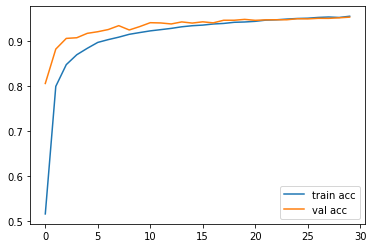

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/acc-rps-NewHB.svg')
plt.show()

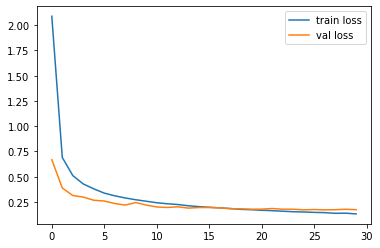

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/loss-rps-NewHB.svg')
plt.show()

In [ ]:
#Installing keras-tuner for hyperparamter search
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.0 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
def model_builder(hp):
    #nets = 15
   # model = [0] *nets
#for j in range(nets):
    model = Sequential()
    hp_filter= hp.Int('filter_value', min_value=32, max_value=128, step=32)
    model.add(Conv2D(filters=hp_filter, kernel_size = 3, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus']), input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp_filter, kernel_size = 3, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp_filter, kernel_size = 5, strides=2, padding='same', activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.25, default=0.5)))

    model.add(Conv2D(filters=hp_filter, kernel_size = 3, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp_filter, kernel_size = 3, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp_filter, kernel_size = 5, strides=2, padding='same', activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.25, default=0.5)))

    model.add(Conv2D(filters=hp_filter, kernel_size = 4, activation=hp.Choice('activation', ['relu', 'sigmoid', 'elu', 'selu', 'softplus'])))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.25, default=0.5)))
    model.add(Dense(302, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    #model.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


    return model
    #Saving the model
    #model.save("/content/drive/MyDrive/MyDrive/Hybrid Amharic Character Dataset1/Figure/Model.h5") #using h5 extension
   # print("model saved!!!")

In [ ]:
#Random search hyperparameter optimization algorithm
tf.keras.backend.reset_uids()
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial = 3,
                     directory='/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure',
                     project_name='new_arc9')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/new_arc9/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/new_arc9/tuner0.json


In [ ]:
# hypertuning settings search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
filter_value (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'elu', 'selu', 'softplus'], 'ordered': False}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.25, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_X, train_Y, validation_data=(val_X,val_Y), callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [ ]:
#Result summarized
tuner.results_summary()


Results summary
Results in /content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/new_arc9
Showing 10 best trials
Trial summary
Hyperparameters:
filter_value: 96
activation: relu
dropout: 0.25
learning_rate: 0.001
Score: 0.8182083368301392
Trial summary
Hyperparameters:
filter_value: 96
activation: relu
dropout: 0.0
learning_rate: 0.01
Score: 0.7585827310880026
Trial summary
Hyperparameters:
filter_value: 96
activation: relu
dropout: 0.25
learning_rate: 0.01
Score: 0.665727416674296
Trial summary
Hyperparameters:
filter_value: 64
activation: sigmoid
dropout: 0.0
learning_rate: 0.001
Score: 0.6383598943551382
Trial summary
Hyperparameters:
filter_value: 128
activation: sigmoid
dropout: 0.25
learning_rate: 0.001
Score: 0.5798678596814474
Trial summary
Hyperparameters:
filter_value: 128
activation: sigmoid
dropout: 0.25
learning_rate: 0.0001
Score: 0.40523383021354675
Trial summary
Hyperparameters:
filter_value: 96
activation: sigmoid
dropout: 0.25
learning_rate: 0.0001
Score: 0.

In [ ]:
#saving the best hyperparamter use it later
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
model = tuner.get_best_models()[0]
model.build(best_hp)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 96)        83040     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        230496    
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 96)       3

In [ ]:
tf.keras.backend.reset_uids()
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
import time
start_time = time.time()
# fit the model
history1 = model.fit(
  train_X,
  train_Y,
  validation_data=(val_X,val_Y),
  epochs=30,
  batch_size=32,shuffle=True)
print("Execution time: " + str((time.time() - start_time)) + ' sec')

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2601/2601 [==============================] - 34s 13ms/step - loss: 0.5539 - accuracy: 0.8396 - val_loss: 0.3266 - val_accuracy: 0.9020
Epoch 2/30
2601/2601 [==============================] - 33s 13ms/step - loss: 0.4009 - accuracy: 0.8795 - val_loss: 0.2979 - val_accuracy: 0.9085
Epoch 3/30
2601/2601 [==============================] - 34s 13ms/step - loss: 0.3248 - accuracy: 0.9015 - val_loss: 0.2398 - val_accuracy: 0.9264
Epoch 4/30
2601/2601 [==============================] - 33s 13ms/step - loss: 0.2809 - accuracy: 0.9144 - val_loss: 0.2354 - val_accuracy: 0.9257
Epoch 5/30
2601/2601 [==============================] - 32s 12ms/step - loss: 0.2498 - accuracy: 0.9230 - val_loss: 0.2095 - val_accuracy: 0.9379
Epoch 6/30
2601/2601 [==============================] - 32s 12ms/step - loss: 0.2226 - accuracy: 0.9308 - val_loss: 0.1947 - val_accuracy: 0.9389
Epoch 7/30
2601/2601 [==============================] - 32s 12ms/step - loss: 0.2012 - accuracy: 0.9370 - val_loss: 1.5434 - val_accura

In [ ]:
#Testing a model with unseen data
model.evaluate(test_X,test_Y,batch_size=32)

334/334 [==============================] - 2s 6ms/step - loss: 0.1779 - accuracy: 0.9602


[0.1778588443994522, 0.9601537585258484]

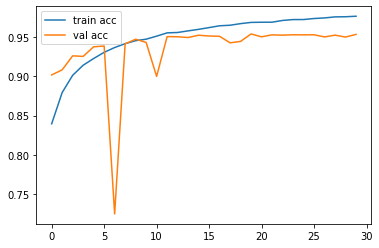

In [ ]:
# Plot an accuracies
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/acc-rps-RS.svg')
plt.show()

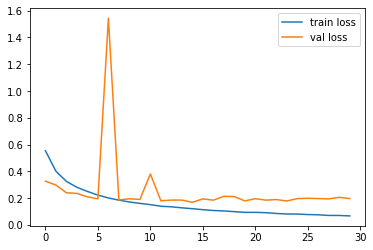

In [ ]:
# loss
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/loss-rps-RS.svg')
plt.show()

In [ ]:
#Saving the model
model.save("/content/drive/MyDrive/Hybrid Amharic Character Dataset1/Figure/AmharicModel.h5") #using h5 extension
print("model saved!!!")